In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import random
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
import timm
from torchmetrics import Accuracy, Precision, Recall, F1Score
import warnings
warnings.filterwarnings('ignore')

# Optimized configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
print(f"🔥 Using device: {device}")

# Data verification
print("📁 Checking data...")
data_path = r"D:\voice_processing\data\SpeechCommands\speech_commands_v0.02"
if os.path.exists(data_path):
    print(f"✅ Data folder found: {data_path}")
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d)) and not d.startswith('_')]
    print(f"🎯 Detected classes: {len(classes)}")
    print(f"📝 Classes: {classes[:10]}...")  # Show first 10 classes
else:
    print("❌ Data folder not found! Automatic download will occur...")

🔥 Using device: cuda
📁 Checking data...
✅ Data folder found: D:\voice_processing\data\SpeechCommands\speech_commands_v0.02
🎯 Detected classes: 35
📝 Classes: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward']...


In [2]:
class ModelConfig:
    def __init__(self):
        # Dropout configuration
        self.input_dropout = 0.1
        self.feature_dropout = 0.4
        self.classifier_dropout = 0.3
        self.drop_path_rate = 0.1
        
        # Training configuration
        self.weight_decay = 0.01
        self.label_smoothing = 0.1
        self.learning_rate = 1e-3
        self.batch_size = 64
        self.num_epochs = 100
        
        # Audio configuration
        self.n_mels = 128
        self.n_fft = 1024
        self.hop_length = 256
        self.sample_rate = 16000
        self.target_length = 16000  # 1 second

config = ModelConfig()
print("⚙️ Model Configuration:")
for key, value in config.__dict__.items():
    print(f"   {key}: {value}")

⚙️ Model Configuration:
   input_dropout: 0.1
   feature_dropout: 0.4
   classifier_dropout: 0.3
   drop_path_rate: 0.1
   weight_decay: 0.01
   label_smoothing: 0.1
   learning_rate: 0.001
   batch_size: 64
   num_epochs: 100
   n_mels: 128
   n_fft: 1024
   hop_length: 256
   sample_rate: 16000
   target_length: 16000


In [3]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.best_acc = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None
        
    def __call__(self, val_loss, val_acc, model):
        should_save = False
        
        # Vérifier amélioration loss ET accuracy
        loss_improved = (self.best_loss is None or 
                        val_loss < self.best_loss - self.min_delta)
        acc_improved = (self.best_acc is None or 
                       val_acc > self.best_acc + self.min_delta)
        
        if loss_improved or acc_improved:
            if loss_improved:
                self.best_loss = val_loss
            if acc_improved:
                self.best_acc = val_acc
            self.counter = 0
            self.best_model_state = model.state_dict().copy()
            should_save = True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"🛑 Early Stopping! Plus d'amélioration depuis {self.patience} epochs")
        
        return self.early_stop
    
    def restore_best_model(self, model):
        if self.restore_best_weights and self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
            print("✅ Meilleurs poids restaurés!")

In [4]:
class AudioAugmentation:
    def __init__(self):
        self.time_stretch = T.TimeStretch()
        self.pitch_shift = T.PitchShift(sample_rate=config.sample_rate, n_steps=4)
        
    def __call__(self, waveform):
        # Time stretching
        if random.random() > 0.6:
            rate = random.uniform(0.85, 1.15)
            try:
                waveform = self.time_stretch(waveform, rate)
            except:
                pass
        
        # Pitch shifting
        if random.random() > 0.6:
            try:
                waveform = self.pitch_shift(waveform)
            except:
                pass
        
        # Gaussian noise
        if random.random() > 0.7:
            noise = torch.randn_like(waveform) * 0.005
            waveform = waveform + noise
        
        # Random gain
        if random.random() > 0.5:
            gain = random.uniform(0.8, 1.2)
            waveform = waveform * gain
            
        return waveform

print("✅ Audio augmentation configured!")

✅ Audio augmentation configured!


In [5]:
class SpeechCommandsDataset(Dataset):
    def __init__(self, subset='training', apply_augmentation=False):
        self.dataset = torchaudio.datasets.SPEECHCOMMANDS(
            root='./data', download=True, subset=subset
        )
        
        self.labels = sorted(list(set([item[2] for item in self.dataset])))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        self.apply_augmentation = apply_augmentation
        self.augment = AudioAugmentation()
        
        print(f"📊 {subset}: {len(self.dataset)} samples, {len(self.labels)} classes")
        
        # Audio transformations
        self.transform = T.MelSpectrogram(
            sample_rate=config.sample_rate,
            n_fft=config.n_fft,
            hop_length=config.hop_length,
            n_mels=config.n_mels,
            f_min=20,
            f_max=8000
        )
        self.to_db = T.AmplitudeToDB()
        
        # SpecAugment
        self.time_mask = T.TimeMasking(time_mask_param=20)
        self.freq_mask = T.FrequencyMasking(freq_mask_param=10)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        waveform, sample_rate, label, speaker_id, utterance_number = self.dataset[idx]
        
        # Resampling
        if sample_rate != config.sample_rate:
            resampler = T.Resample(sample_rate, config.sample_rate)
            waveform = resampler(waveform)
        
        # Normalization
        waveform = waveform / (waveform.abs().max() + 1e-8)
        
        # Augmentation
        if self.apply_augmentation and random.random() > 0.5:
            waveform = self.augment(waveform)
        
        # Padding/truncation
        current_length = waveform.shape[1]
        if current_length < config.target_length:
            waveform = F.pad(waveform, (0, config.target_length - current_length))
        else:
            if self.apply_augmentation:
                start = random.randint(0, current_length - config.target_length)
            else:
                start = (current_length - config.target_length) // 2
            waveform = waveform[:, start:start + config.target_length]
        
        # Mel Spectrogram
        mel_spec = self.transform(waveform)
        mel_spec_db = self.to_db(mel_spec)
        
        # SpecAugment for training
        if self.apply_augmentation:
            mel_spec_db = self.time_mask(mel_spec_db)
            mel_spec_db = self.freq_mask(mel_spec_db)
        
        # Normalization
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        
        # 3 channels for EfficientNet
        mel_spec_3ch = mel_spec_db.repeat(3, 1, 1)
        
        label_idx = self.label_to_idx[label]
        
        return mel_spec_3ch, label_idx

print("✅ Dataset configured!")

✅ Dataset configured!


In [6]:
class AdvancedAudioClassifier(nn.Module):
    def __init__(self, num_classes=35, dropout_config=None):
        super().__init__()
        self.config = dropout_config if dropout_config else config
        
        # MobileNetV3 backbone with transfer learning
        self.backbone = timm.create_model(
            'mobilenetv3_large_100',
            pretrained=True,
            in_chans=3,
            num_classes=0,  # Pas de classificateur final
            drop_path_rate=self.config.drop_path_rate
        )
        
        # MobileNetV3 large a 1280 features de sortie (au lieu de 1280 pour EfficientNet-B0)
        feature_dim = 1280  # Dimension fixe pour MobileNetV3 large
        
        # Input dropout
        self.input_dropout = nn.Dropout2d(self.config.input_dropout)
        
        # Classifier avec progressive dropout - ADAPTÉ pour MobileNetV3
        self.classifier = nn.Sequential(
            nn.Dropout(self.config.feature_dropout),
            nn.Linear(feature_dim, 1024),  # 1280 -> 1024
            nn.BatchNorm1d(1024),
            nn.GELU(),
            
            nn.Dropout(self.config.feature_dropout * 0.7),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            
            nn.Dropout(self.config.feature_dropout * 0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            
            nn.Dropout(self.config.classifier_dropout),
            nn.Linear(256, num_classes)
        )
        
        # Optionnel: Geler les premières couches
        self._freeze_early_layers()
        
    def _freeze_early_layers(self):
        """Geler les premières couches de MobileNetV3"""
        frozen_count = 0
        total_count = 0
        
        for name, param in self.backbone.named_parameters():
            total_count += 1
            # Geler les blocs 0-4 (sur 7 blocs au total)
            if any(f'blocks.{i}' in name for i in [0, 1, 2, 3, 4]):
                param.requires_grad = False
                frozen_count += 1
            else:
                param.requires_grad = True
                
        print(f"❄️ {frozen_count}/{total_count} couches gelées dans le backbone")
        
    def forward(self, x):
        # Input dropout during training only
        if self.training and self.config.input_dropout > 0:
            x = self.input_dropout(x)
        
        features = self.backbone(x)
        return self.classifier(features)

print("✅ Model MobileNetV3 avec dropout avancé créé!")

✅ Model MobileNetV3 avec dropout avancé créé!


Cell 2: Imports and Configuration

In [7]:
class LabelSmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, x, target):
        log_probs = F.log_softmax(x, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

print("✅ Loss function with label smoothing configured!")

✅ Loss function with label smoothing configured!


In [8]:
print("🔧 Smart dataset loading...")

# CONFIG: Choose your speed preference
FAST_MODE = True  # Set to True for quick testing, False for full training
SUBSET_SIZE = 5000 if FAST_MODE else None  # Use subset if fast mode

class SmartSpeechCommandsDataset(Dataset):
    """Smart dataset that balances speed and quality"""
    
    def __init__(self, subset='training', apply_augmentation=False):
        self.dataset = torchaudio.datasets.SPEECHCOMMANDS(
            root=r"D:\voice_processing\data", download=True, subset=subset
        )
        
        # Apply subset if in fast mode
        if FAST_MODE and SUBSET_SIZE and len(self.dataset) > SUBSET_SIZE:
            indices = torch.randperm(len(self.dataset))[:SUBSET_SIZE]
            self.dataset = torch.utils.data.Subset(self.dataset, indices)
            print(f"⚡ FAST MODE: Using {SUBSET_SIZE} samples")
        
        self.labels = sorted(list(set([item[2] for item in self.dataset])))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        self.apply_augmentation = apply_augmentation
        
        # Optimized transformations
        self.transform = T.MelSpectrogram(
            sample_rate=config.sample_rate,
            n_fft=config.n_fft,
            hop_length=config.hop_length,
            n_mels=config.n_mels,
        )
        self.to_db = T.AmplitudeToDB()
        
        mode = "FAST" if FAST_MODE else "FULL"
        print(f"📊 {subset} ({mode}): {len(self.dataset)} samples, {len(self.labels)} classes")
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        # Get data
        if isinstance(self.dataset, torch.utils.data.Subset):
            waveform, sample_rate, label, speaker_id, utterance_number = self.dataset.dataset[self.dataset.indices[idx]]
        else:
            waveform, sample_rate, label, speaker_id, utterance_number = self.dataset[idx]
        
        # Fast processing (skip some augmentations in fast mode)
        if sample_rate != config.sample_rate:
            resampler = T.Resample(sample_rate, config.sample_rate)
            waveform = resampler(waveform)
        
        waveform = waveform / (waveform.abs().max() + 1e-8)
        
        # Limited augmentation in fast mode
        if self.apply_augmentation and not FAST_MODE and random.random() > 0.5:
            augmenter = AudioAugmentation()
            waveform = augmenter(waveform)
        
        # Padding/truncation
        current_length = waveform.shape[1]
        if current_length < config.target_length:
            waveform = F.pad(waveform, (0, config.target_length - current_length))
        else:
            waveform = waveform[:, :config.target_length]
        
        # Spectrogram
        mel_spec = self.transform(waveform)
        mel_spec_db = self.to_db(mel_spec)
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        mel_spec_3ch = mel_spec_db.repeat(3, 1, 1)
        
        label_idx = self.label_to_idx[label]
        return mel_spec_3ch, label_idx

# Load datasets
print("📥 Loading datasets...")
train_dataset = SmartSpeechCommandsDataset(subset='training', apply_augmentation=True)
val_dataset = SmartSpeechCommandsDataset(subset='validation', apply_augmentation=False)
test_dataset = SmartSpeechCommandsDataset(subset='testing', apply_augmentation=False)

num_classes = len(train_dataset.labels)

# Adjust batch size based on mode
batch_size = 32 if FAST_MODE else config.batch_size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print("✅ Data loaded successfully!")
print(f"📊 Summary:")
print(f"   - Mode: {'FAST (Testing)' if FAST_MODE else 'FULL (Training)'}")
print(f"   - Batch size: {batch_size}")
print(f"   - Training samples: {len(train_dataset):,}")
print(f"   - Classes: {num_classes}")
print(f"💡 Change FAST_MODE = False for full training")

🔧 Smart dataset loading...
📥 Loading datasets...
⚡ FAST MODE: Using 5000 samples
📊 training (FAST): 5000 samples, 35 classes
⚡ FAST MODE: Using 5000 samples
📊 validation (FAST): 5000 samples, 35 classes
⚡ FAST MODE: Using 5000 samples
📊 testing (FAST): 5000 samples, 35 classes
✅ Data loaded successfully!
📊 Summary:
   - Mode: FAST (Testing)
   - Batch size: 32
   - Training samples: 5,000
   - Classes: 35
💡 Change FAST_MODE = False for full training


In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='🚀 Training')
    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        accuracy = 100. * correct / total
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Accuracy': f'{accuracy:.2f}%'
        })
    
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    """Validation"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(loader, desc='📊 Validation'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

print("✅ Training functions created!")

✅ Training functions created!


In [10]:
print("🚀 Starting training with Early Stopping and Dropout...")

# VERIFICATION: Check if num_classes exists
if 'num_classes' not in locals():
    print("❌ num_classes not found, creating datasets...")
    train_dataset = SpeechCommandsDataset(subset='training', apply_augmentation=True)
    num_classes = len(train_dataset.labels)
    print(f"✅ num_classes created: {num_classes}")

# Initialize model
model = AdvancedAudioClassifier(num_classes=num_classes).to(device)

# Display model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Model created:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Dropout rate: {config.feature_dropout}")

# Loss function with label smoothing
criterion = LabelSmoothCrossEntropyLoss(smoothing=config.label_smoothing)

# Optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay,
    betas=(0.9, 0.999)
)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.num_epochs)

# Early Stopping
early_stopping = EarlyStopping(patience=12, min_delta=0.002)

# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'learning_rates': []
}

best_val_acc = 0
print(f"\n🎯 Starting training for {config.num_epochs} epochs...")

for epoch in range(config.num_epochs):
    print(f"\n📍 Epoch {epoch+1}/{config.num_epochs}")
    
    # Training phase (dropout enabled)
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation phase (dropout disabled)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    
    print(f"  Train → Loss: {train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"  Val   → Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Early Stopping check
    if early_stopping(val_loss, val_acc, model):
        print(f"\n🛑 Early Stopping triggered at epoch {epoch + 1}!")
        early_stopping.restore_best_model(model)
        break
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  💾 Best model saved! (Accuracy: {val_acc:.2f}%)")
    
    # Adjust learning rate
    scheduler.step()

print(f"\n🎉 Training completed!")
print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")
print(f"📈 Effective epochs: {epoch + 1}")

🚀 Starting training with Early Stopping and Dropout...
❄️ 125/172 couches gelées dans le backbone
📊 Model created:
   - Total parameters: 6,182,483
   - Trainable parameters: 5,390,459
   - Dropout rate: 0.4

🎯 Starting training for 100 epochs...

📍 Epoch 1/100


📊 Validation: 100%|██████████| 157/157 [00:29<00:00,  5.39it/s]


  Train → Loss: 3.4008 | Accuracy: 8.34%
  Val   → Loss: 3.0615 | Accuracy: 18.28%
  LR: 1.00e-03
  💾 Best model saved! (Accuracy: 18.28%)

📍 Epoch 2/100


📊 Validation: 100%|██████████| 157/157 [00:28<00:00,  5.51it/s]


  Train → Loss: 2.9359 | Accuracy: 20.80%
  Val   → Loss: 2.6169 | Accuracy: 30.12%
  LR: 1.00e-03
  💾 Best model saved! (Accuracy: 30.12%)

📍 Epoch 3/100


📊 Validation: 100%|██████████| 157/157 [00:28<00:00,  5.56it/s]


  Train → Loss: 2.5414 | Accuracy: 35.04%
  Val   → Loss: 2.2093 | Accuracy: 44.44%
  LR: 9.99e-04
  💾 Best model saved! (Accuracy: 44.44%)

📍 Epoch 4/100


📊 Validation: 100%|██████████| 157/157 [00:28<00:00,  5.49it/s]


  Train → Loss: 2.2393 | Accuracy: 44.40%
  Val   → Loss: 2.0664 | Accuracy: 50.06%
  LR: 9.98e-04
  💾 Best model saved! (Accuracy: 50.06%)

📍 Epoch 5/100


📊 Validation: 100%|██████████| 157/157 [00:11<00:00, 14.16it/s]


  Train → Loss: 1.9994 | Accuracy: 52.94%
  Val   → Loss: 1.9157 | Accuracy: 55.48%
  LR: 9.96e-04
  💾 Best model saved! (Accuracy: 55.48%)

📍 Epoch 6/100


📊 Validation: 100%|██████████| 157/157 [00:11<00:00, 13.23it/s]


  Train → Loss: 1.8344 | Accuracy: 59.94%
  Val   → Loss: 1.8231 | Accuracy: 59.66%
  LR: 9.94e-04
  💾 Best model saved! (Accuracy: 59.66%)

📍 Epoch 7/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.50it/s]


  Train → Loss: 1.6824 | Accuracy: 65.70%
  Val   → Loss: 1.8121 | Accuracy: 58.86%
  LR: 9.91e-04

📍 Epoch 8/100


📊 Validation: 100%|██████████| 157/157 [00:29<00:00,  5.25it/s]


  Train → Loss: 1.6020 | Accuracy: 67.42%
  Val   → Loss: 1.7800 | Accuracy: 61.00%
  LR: 9.88e-04
  💾 Best model saved! (Accuracy: 61.00%)

📍 Epoch 9/100


📊 Validation: 100%|██████████| 157/157 [00:27<00:00,  5.70it/s]


  Train → Loss: 1.4873 | Accuracy: 72.44%
  Val   → Loss: 1.7417 | Accuracy: 62.04%
  LR: 9.84e-04
  💾 Best model saved! (Accuracy: 62.04%)

📍 Epoch 10/100


📊 Validation: 100%|██████████| 157/157 [00:29<00:00,  5.36it/s]


  Train → Loss: 1.4120 | Accuracy: 75.42%
  Val   → Loss: 1.7634 | Accuracy: 62.26%
  LR: 9.80e-04
  💾 Best model saved! (Accuracy: 62.26%)

📍 Epoch 11/100


📊 Validation: 100%|██████████| 157/157 [00:29<00:00,  5.37it/s]


  Train → Loss: 1.3319 | Accuracy: 78.36%
  Val   → Loss: 1.7680 | Accuracy: 63.18%
  LR: 9.76e-04
  💾 Best model saved! (Accuracy: 63.18%)

📍 Epoch 12/100


📊 Validation: 100%|██████████| 157/157 [00:30<00:00,  5.12it/s]


  Train → Loss: 1.2869 | Accuracy: 80.82%
  Val   → Loss: 1.6719 | Accuracy: 65.64%
  LR: 9.70e-04
  💾 Best model saved! (Accuracy: 65.64%)

📍 Epoch 13/100


📊 Validation: 100%|██████████| 157/157 [00:29<00:00,  5.38it/s]


  Train → Loss: 1.2291 | Accuracy: 82.20%
  Val   → Loss: 1.6741 | Accuracy: 65.52%
  LR: 9.65e-04

📍 Epoch 14/100


📊 Validation: 100%|██████████| 157/157 [00:33<00:00,  4.74it/s]


  Train → Loss: 1.1984 | Accuracy: 83.50%
  Val   → Loss: 1.6649 | Accuracy: 66.88%
  LR: 9.59e-04
  💾 Best model saved! (Accuracy: 66.88%)

📍 Epoch 15/100


📊 Validation: 100%|██████████| 157/157 [00:27<00:00,  5.74it/s]


  Train → Loss: 1.1594 | Accuracy: 84.72%
  Val   → Loss: 1.6732 | Accuracy: 66.30%
  LR: 9.52e-04

📍 Epoch 16/100


📊 Validation: 100%|██████████| 157/157 [00:32<00:00,  4.89it/s]


  Train → Loss: 1.1447 | Accuracy: 85.20%
  Val   → Loss: 1.6589 | Accuracy: 66.82%
  LR: 9.46e-04

📍 Epoch 17/100


📊 Validation: 100%|██████████| 157/157 [00:30<00:00,  5.22it/s]


  Train → Loss: 1.1135 | Accuracy: 86.50%
  Val   → Loss: 1.6176 | Accuracy: 68.42%
  LR: 9.38e-04
  💾 Best model saved! (Accuracy: 68.42%)

📍 Epoch 18/100


📊 Validation: 100%|██████████| 157/157 [00:30<00:00,  5.12it/s]


  Train → Loss: 1.0869 | Accuracy: 87.28%
  Val   → Loss: 1.6575 | Accuracy: 67.32%
  LR: 9.30e-04

📍 Epoch 19/100


📊 Validation: 100%|██████████| 157/157 [00:30<00:00,  5.15it/s]


  Train → Loss: 1.0575 | Accuracy: 88.24%
  Val   → Loss: 1.6553 | Accuracy: 67.44%
  LR: 9.22e-04

📍 Epoch 20/100


📊 Validation: 100%|██████████| 157/157 [00:31<00:00,  5.03it/s]


  Train → Loss: 1.0388 | Accuracy: 89.10%
  Val   → Loss: 1.6266 | Accuracy: 68.78%
  LR: 9.14e-04
  💾 Best model saved! (Accuracy: 68.78%)

📍 Epoch 21/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.99it/s]


  Train → Loss: 1.0327 | Accuracy: 88.80%
  Val   → Loss: 1.6506 | Accuracy: 67.94%
  LR: 9.05e-04

📍 Epoch 22/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.11it/s]


  Train → Loss: 1.0012 | Accuracy: 90.20%
  Val   → Loss: 1.6800 | Accuracy: 67.88%
  LR: 8.95e-04

📍 Epoch 23/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.55it/s]


  Train → Loss: 0.9863 | Accuracy: 90.30%
  Val   → Loss: 1.6457 | Accuracy: 68.26%
  LR: 8.85e-04

📍 Epoch 24/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.55it/s]


  Train → Loss: 0.9640 | Accuracy: 91.74%
  Val   → Loss: 1.6258 | Accuracy: 69.44%
  LR: 8.75e-04
  💾 Best model saved! (Accuracy: 69.44%)

📍 Epoch 25/100


📊 Validation: 100%|██████████| 157/157 [00:28<00:00,  5.48it/s]


  Train → Loss: 0.9747 | Accuracy: 91.20%
  Val   → Loss: 1.5950 | Accuracy: 69.10%
  LR: 8.64e-04

📍 Epoch 26/100


📊 Validation: 100%|██████████| 157/157 [00:26<00:00,  5.86it/s]


  Train → Loss: 0.9571 | Accuracy: 91.84%
  Val   → Loss: 1.6392 | Accuracy: 68.22%
  LR: 8.54e-04

📍 Epoch 27/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.46it/s]


  Train → Loss: 0.9377 | Accuracy: 92.14%
  Val   → Loss: 1.6332 | Accuracy: 68.00%
  LR: 8.42e-04

📍 Epoch 28/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.98it/s]


  Train → Loss: 0.9298 | Accuracy: 92.58%
  Val   → Loss: 1.6499 | Accuracy: 68.22%
  LR: 8.31e-04

📍 Epoch 29/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.03it/s]


  Train → Loss: 0.9182 | Accuracy: 92.64%
  Val   → Loss: 1.6763 | Accuracy: 67.50%
  LR: 8.19e-04

📍 Epoch 30/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.91it/s]


  Train → Loss: 0.9124 | Accuracy: 92.84%
  Val   → Loss: 1.6493 | Accuracy: 68.48%
  LR: 8.06e-04

📍 Epoch 31/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.10it/s]


  Train → Loss: 0.8829 | Accuracy: 93.88%
  Val   → Loss: 1.6159 | Accuracy: 69.74%
  LR: 7.94e-04
  💾 Best model saved! (Accuracy: 69.74%)

📍 Epoch 32/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s]


  Train → Loss: 0.8915 | Accuracy: 93.54%
  Val   → Loss: 1.5942 | Accuracy: 70.32%
  LR: 7.81e-04
  💾 Best model saved! (Accuracy: 70.32%)

📍 Epoch 33/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.92it/s]


  Train → Loss: 0.8814 | Accuracy: 93.96%
  Val   → Loss: 1.5991 | Accuracy: 70.66%
  LR: 7.68e-04
  💾 Best model saved! (Accuracy: 70.66%)

📍 Epoch 34/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.06it/s]


  Train → Loss: 0.8818 | Accuracy: 94.22%
  Val   → Loss: 1.5825 | Accuracy: 71.06%
  LR: 7.55e-04
  💾 Best model saved! (Accuracy: 71.06%)

📍 Epoch 35/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.71it/s]


  Train → Loss: 0.8804 | Accuracy: 94.10%
  Val   → Loss: 1.5965 | Accuracy: 70.68%
  LR: 7.41e-04

📍 Epoch 36/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.26it/s]


  Train → Loss: 0.8527 | Accuracy: 95.00%
  Val   → Loss: 1.6141 | Accuracy: 70.20%
  LR: 7.27e-04

📍 Epoch 37/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.83it/s]


  Train → Loss: 0.8640 | Accuracy: 94.54%
  Val   → Loss: 1.6184 | Accuracy: 70.16%
  LR: 7.13e-04

📍 Epoch 38/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.96it/s]


  Train → Loss: 0.8524 | Accuracy: 94.58%
  Val   → Loss: 1.5866 | Accuracy: 70.96%
  LR: 6.99e-04

📍 Epoch 39/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.48it/s]


  Train → Loss: 0.8492 | Accuracy: 95.14%
  Val   → Loss: 1.5805 | Accuracy: 70.96%
  LR: 6.84e-04

📍 Epoch 40/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.01it/s]


  Train → Loss: 0.8443 | Accuracy: 95.04%
  Val   → Loss: 1.5774 | Accuracy: 71.04%
  LR: 6.69e-04

📍 Epoch 41/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.41it/s]


  Train → Loss: 0.8169 | Accuracy: 96.06%
  Val   → Loss: 1.6243 | Accuracy: 70.10%
  LR: 6.55e-04

📍 Epoch 42/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.73it/s]


  Train → Loss: 0.8206 | Accuracy: 95.96%
  Val   → Loss: 1.5431 | Accuracy: 72.06%
  LR: 6.39e-04
  💾 Best model saved! (Accuracy: 72.06%)

📍 Epoch 43/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.98it/s]


  Train → Loss: 0.8154 | Accuracy: 96.06%
  Val   → Loss: 1.5969 | Accuracy: 70.54%
  LR: 6.24e-04

📍 Epoch 44/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.76it/s]


  Train → Loss: 0.8253 | Accuracy: 95.94%
  Val   → Loss: 1.5955 | Accuracy: 70.82%
  LR: 6.09e-04

📍 Epoch 45/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.08it/s]


  Train → Loss: 0.8067 | Accuracy: 96.22%
  Val   → Loss: 1.5528 | Accuracy: 72.54%
  LR: 5.94e-04
  💾 Best model saved! (Accuracy: 72.54%)

📍 Epoch 46/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.19it/s]


  Train → Loss: 0.7956 | Accuracy: 96.72%
  Val   → Loss: 1.5519 | Accuracy: 71.72%
  LR: 5.78e-04

📍 Epoch 47/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.02it/s]


  Train → Loss: 0.7956 | Accuracy: 96.56%
  Val   → Loss: 1.5653 | Accuracy: 71.70%
  LR: 5.63e-04

📍 Epoch 48/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.59it/s]


  Train → Loss: 0.7949 | Accuracy: 96.62%
  Val   → Loss: 1.5738 | Accuracy: 71.26%
  LR: 5.47e-04

📍 Epoch 49/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.14it/s]


  Train → Loss: 0.7807 | Accuracy: 97.04%
  Val   → Loss: 1.5781 | Accuracy: 71.44%
  LR: 5.31e-04

📍 Epoch 50/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.46it/s]


  Train → Loss: 0.7908 | Accuracy: 96.94%
  Val   → Loss: 1.5585 | Accuracy: 72.00%
  LR: 5.16e-04

📍 Epoch 51/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.68it/s]


  Train → Loss: 0.7931 | Accuracy: 96.90%
  Val   → Loss: 1.5454 | Accuracy: 72.36%
  LR: 5.00e-04

📍 Epoch 52/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.12it/s]


  Train → Loss: 0.7853 | Accuracy: 97.12%
  Val   → Loss: 1.5811 | Accuracy: 71.26%
  LR: 4.84e-04

📍 Epoch 53/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.98it/s]


  Train → Loss: 0.7882 | Accuracy: 96.98%
  Val   → Loss: 1.5594 | Accuracy: 72.00%
  LR: 4.69e-04

📍 Epoch 54/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.96it/s]


  Train → Loss: 0.7804 | Accuracy: 97.30%
  Val   → Loss: 1.5484 | Accuracy: 71.78%
  LR: 4.53e-04

📍 Epoch 55/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 17.66it/s]


  Train → Loss: 0.7846 | Accuracy: 96.96%
  Val   → Loss: 1.5574 | Accuracy: 72.30%
  LR: 4.37e-04

📍 Epoch 56/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.84it/s]


  Train → Loss: 0.7673 | Accuracy: 97.50%
  Val   → Loss: 1.5549 | Accuracy: 71.94%
  LR: 4.22e-04

📍 Epoch 57/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.40it/s]


  Train → Loss: 0.7758 | Accuracy: 97.48%
  Val   → Loss: 1.5401 | Accuracy: 72.82%
  LR: 4.06e-04
  💾 Best model saved! (Accuracy: 72.82%)

📍 Epoch 58/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.57it/s]


  Train → Loss: 0.7620 | Accuracy: 97.78%
  Val   → Loss: 1.5530 | Accuracy: 72.18%
  LR: 3.91e-04

📍 Epoch 59/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.96it/s]


  Train → Loss: 0.7511 | Accuracy: 97.98%
  Val   → Loss: 1.5544 | Accuracy: 72.46%
  LR: 3.76e-04

📍 Epoch 60/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.06it/s]


  Train → Loss: 0.7510 | Accuracy: 98.12%
  Val   → Loss: 1.5422 | Accuracy: 72.18%
  LR: 3.61e-04

📍 Epoch 61/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.42it/s]


  Train → Loss: 0.7503 | Accuracy: 98.06%
  Val   → Loss: 1.5306 | Accuracy: 73.12%
  LR: 3.45e-04
  💾 Best model saved! (Accuracy: 73.12%)

📍 Epoch 62/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.90it/s]


  Train → Loss: 0.7516 | Accuracy: 98.00%
  Val   → Loss: 1.5514 | Accuracy: 72.02%
  LR: 3.31e-04

📍 Epoch 63/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.47it/s]


  Train → Loss: 0.7467 | Accuracy: 98.18%
  Val   → Loss: 1.5476 | Accuracy: 72.68%
  LR: 3.16e-04

📍 Epoch 64/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.51it/s]


  Train → Loss: 0.7428 | Accuracy: 98.30%
  Val   → Loss: 1.5418 | Accuracy: 72.84%
  LR: 3.01e-04

📍 Epoch 65/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.26it/s]


  Train → Loss: 0.7408 | Accuracy: 98.34%
  Val   → Loss: 1.5360 | Accuracy: 72.92%
  LR: 2.87e-04

📍 Epoch 66/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.09it/s]


  Train → Loss: 0.7370 | Accuracy: 98.46%
  Val   → Loss: 1.5301 | Accuracy: 72.54%
  LR: 2.73e-04

📍 Epoch 67/100


📊 Validation: 100%|██████████| 157/157 [00:10<00:00, 14.40it/s]


  Train → Loss: 0.7312 | Accuracy: 98.58%
  Val   → Loss: 1.5230 | Accuracy: 72.62%
  LR: 2.59e-04

📍 Epoch 68/100


📊 Validation: 100%|██████████| 157/157 [00:30<00:00,  5.14it/s]


  Train → Loss: 0.7281 | Accuracy: 98.68%
  Val   → Loss: 1.5315 | Accuracy: 72.48%
  LR: 2.45e-04

📍 Epoch 69/100


📊 Validation: 100%|██████████| 157/157 [00:26<00:00,  5.84it/s]


  Train → Loss: 0.7393 | Accuracy: 98.32%
  Val   → Loss: 1.5576 | Accuracy: 72.22%
  LR: 2.32e-04

📍 Epoch 70/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.76it/s]


  Train → Loss: 0.7390 | Accuracy: 98.44%
  Val   → Loss: 1.5275 | Accuracy: 72.98%
  LR: 2.19e-04

📍 Epoch 71/100


📊 Validation: 100%|██████████| 157/157 [00:25<00:00,  6.11it/s]


  Train → Loss: 0.7338 | Accuracy: 98.42%
  Val   → Loss: 1.5319 | Accuracy: 72.54%
  LR: 2.06e-04

📍 Epoch 72/100


📊 Validation: 100%|██████████| 157/157 [00:26<00:00,  5.84it/s]


  Train → Loss: 0.7297 | Accuracy: 98.84%
  Val   → Loss: 1.5125 | Accuracy: 73.14%
  LR: 1.94e-04
  💾 Best model saved! (Accuracy: 73.14%)

📍 Epoch 73/100


📊 Validation: 100%|██████████| 157/157 [00:24<00:00,  6.51it/s]


  Train → Loss: 0.7257 | Accuracy: 98.64%
  Val   → Loss: 1.5127 | Accuracy: 73.16%
  LR: 1.81e-04
  💾 Best model saved! (Accuracy: 73.16%)

📍 Epoch 74/100


📊 Validation: 100%|██████████| 157/157 [00:24<00:00,  6.41it/s]


  Train → Loss: 0.7263 | Accuracy: 98.76%
  Val   → Loss: 1.5117 | Accuracy: 73.24%
  LR: 1.69e-04
  💾 Best model saved! (Accuracy: 73.24%)

📍 Epoch 75/100


📊 Validation: 100%|██████████| 157/157 [00:26<00:00,  6.02it/s]


  Train → Loss: 0.7286 | Accuracy: 98.74%
  Val   → Loss: 1.5251 | Accuracy: 72.74%
  LR: 1.58e-04

📍 Epoch 76/100


📊 Validation: 100%|██████████| 157/157 [00:30<00:00,  5.11it/s]


  Train → Loss: 0.7316 | Accuracy: 98.56%
  Val   → Loss: 1.5123 | Accuracy: 73.40%
  LR: 1.46e-04
  💾 Best model saved! (Accuracy: 73.40%)

📍 Epoch 77/100


📊 Validation: 100%|██████████| 157/157 [00:23<00:00,  6.63it/s]


  Train → Loss: 0.7309 | Accuracy: 98.50%
  Val   → Loss: 1.5084 | Accuracy: 73.20%
  LR: 1.36e-04

📍 Epoch 78/100


📊 Validation: 100%|██████████| 157/157 [00:23<00:00,  6.56it/s]


  Train → Loss: 0.7267 | Accuracy: 98.64%
  Val   → Loss: 1.5167 | Accuracy: 73.30%
  LR: 1.25e-04

📍 Epoch 79/100


📊 Validation: 100%|██████████| 157/157 [00:24<00:00,  6.46it/s]


  Train → Loss: 0.7334 | Accuracy: 98.66%
  Val   → Loss: 1.5103 | Accuracy: 73.38%
  LR: 1.15e-04

📍 Epoch 80/100


📊 Validation: 100%|██████████| 157/157 [00:27<00:00,  5.77it/s]


  Train → Loss: 0.7200 | Accuracy: 99.04%
  Val   → Loss: 1.5014 | Accuracy: 73.46%
  LR: 1.05e-04
  💾 Best model saved! (Accuracy: 73.46%)

📍 Epoch 81/100


📊 Validation: 100%|██████████| 157/157 [00:25<00:00,  6.09it/s]


  Train → Loss: 0.7289 | Accuracy: 98.52%
  Val   → Loss: 1.4825 | Accuracy: 74.12%
  LR: 9.55e-05
  💾 Best model saved! (Accuracy: 74.12%)

📍 Epoch 82/100


📊 Validation: 100%|██████████| 157/157 [00:25<00:00,  6.17it/s]


  Train → Loss: 0.7286 | Accuracy: 98.84%
  Val   → Loss: 1.4954 | Accuracy: 73.86%
  LR: 8.65e-05

📍 Epoch 83/100


📊 Validation: 100%|██████████| 157/157 [00:28<00:00,  5.45it/s]


  Train → Loss: 0.7182 | Accuracy: 99.02%
  Val   → Loss: 1.4939 | Accuracy: 74.00%
  LR: 7.78e-05

📍 Epoch 84/100


📊 Validation: 100%|██████████| 157/157 [00:27<00:00,  5.64it/s]


  Train → Loss: 0.7222 | Accuracy: 98.98%
  Val   → Loss: 1.5178 | Accuracy: 73.42%
  LR: 6.96e-05

📍 Epoch 85/100


📊 Validation: 100%|██████████| 157/157 [00:25<00:00,  6.22it/s]


  Train → Loss: 0.7172 | Accuracy: 99.10%
  Val   → Loss: 1.4788 | Accuracy: 73.92%
  LR: 6.18e-05

📍 Epoch 86/100


📊 Validation: 100%|██████████| 157/157 [00:25<00:00,  6.16it/s]


  Train → Loss: 0.7251 | Accuracy: 98.74%
  Val   → Loss: 1.4916 | Accuracy: 73.92%
  LR: 5.45e-05

📍 Epoch 87/100


📊 Validation: 100%|██████████| 157/157 [00:26<00:00,  5.87it/s]


  Train → Loss: 0.7218 | Accuracy: 98.82%
  Val   → Loss: 1.4885 | Accuracy: 74.04%
  LR: 4.76e-05

📍 Epoch 88/100


📊 Validation: 100%|██████████| 157/157 [00:26<00:00,  5.82it/s]


  Train → Loss: 0.7211 | Accuracy: 98.80%
  Val   → Loss: 1.4979 | Accuracy: 73.24%
  LR: 4.11e-05

📍 Epoch 89/100


📊 Validation: 100%|██████████| 157/157 [00:16<00:00,  9.67it/s]


  Train → Loss: 0.7219 | Accuracy: 98.76%
  Val   → Loss: 1.4916 | Accuracy: 73.80%
  LR: 3.51e-05

📍 Epoch 90/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 19.08it/s]


  Train → Loss: 0.7241 | Accuracy: 98.78%
  Val   → Loss: 1.4893 | Accuracy: 73.54%
  LR: 2.96e-05

📍 Epoch 91/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.69it/s]


  Train → Loss: 0.7232 | Accuracy: 98.80%
  Val   → Loss: 1.4981 | Accuracy: 73.40%
  LR: 2.45e-05

📍 Epoch 92/100


📊 Validation: 100%|██████████| 157/157 [00:21<00:00,  7.18it/s]


  Train → Loss: 0.7188 | Accuracy: 98.96%
  Val   → Loss: 1.4799 | Accuracy: 73.84%
  LR: 1.99e-05

📍 Epoch 93/100


📊 Validation: 100%|██████████| 157/157 [00:25<00:00,  6.13it/s]


  Train → Loss: 0.7162 | Accuracy: 99.00%
  Val   → Loss: 1.5005 | Accuracy: 73.34%
  LR: 1.57e-05

📍 Epoch 94/100


📊 Validation: 100%|██████████| 157/157 [00:26<00:00,  6.03it/s]


  Train → Loss: 0.7199 | Accuracy: 98.92%
  Val   → Loss: 1.4805 | Accuracy: 74.24%
  LR: 1.20e-05
  💾 Best model saved! (Accuracy: 74.24%)

📍 Epoch 95/100


📊 Validation: 100%|██████████| 157/157 [00:27<00:00,  5.70it/s]


  Train → Loss: 0.7144 | Accuracy: 99.10%
  Val   → Loss: 1.4854 | Accuracy: 74.10%
  LR: 8.86e-06

📍 Epoch 96/100


📊 Validation: 100%|██████████| 157/157 [00:08<00:00, 18.53it/s]


  Train → Loss: 0.7156 | Accuracy: 99.14%
  Val   → Loss: 1.5016 | Accuracy: 73.26%
  LR: 6.16e-06

📍 Epoch 97/100


📊 Validation: 100%|██████████| 157/157 [00:12<00:00, 12.28it/s]


  Train → Loss: 0.7145 | Accuracy: 99.08%
  Val   → Loss: 1.4896 | Accuracy: 73.62%
  LR: 3.94e-06

📍 Epoch 98/100


📊 Validation: 100%|██████████| 157/157 [00:30<00:00,  5.08it/s]


  Train → Loss: 0.7202 | Accuracy: 98.72%
  Val   → Loss: 1.4870 | Accuracy: 73.96%
  LR: 2.22e-06

📍 Epoch 99/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 19.92it/s]


  Train → Loss: 0.7161 | Accuracy: 98.88%
  Val   → Loss: 1.4946 | Accuracy: 73.58%
  LR: 9.87e-07

📍 Epoch 100/100


📊 Validation: 100%|██████████| 157/157 [00:07<00:00, 20.46it/s]

  Train → Loss: 0.7164 | Accuracy: 99.08%
  Val   → Loss: 1.4982 | Accuracy: 73.60%
  LR: 2.47e-07

🎉 Training completed!
🏆 Best validation accuracy: 74.24%
📈 Effective epochs: 100


In [11]:
print("📊 Evaluating model...")

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluation on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"🎯 Test set performance:")
print(f"   - Loss: {test_loss:.4f}")
print(f"   - Accuracy: {test_acc:.2f}%")

# Detailed metrics
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds, average='macro')
precision = precision_score(all_targets, all_preds, average='macro')
recall = recall_score(all_targets, all_preds, average='macro')

print(f"\n📈 Detailed metrics:")
print(f"   - Accuracy: {accuracy:.4f}")
print(f"   - F1-Score: {f1:.4f}")
print(f"   - Precision: {precision:.4f}")
print(f"   - Recall: {recall:.4f}")

📊 Evaluating model...


📊 Validation: 100%|██████████| 157/157 [00:09<00:00, 17.10it/s]


🎯 Test set performance:
   - Loss: 1.5292
   - Accuracy: 72.98%

📈 Detailed metrics:
   - Accuracy: 0.7298
   - F1-Score: 0.7180
   - Precision: 0.7260
   - Recall: 0.7157


📊 Creating visualizations...


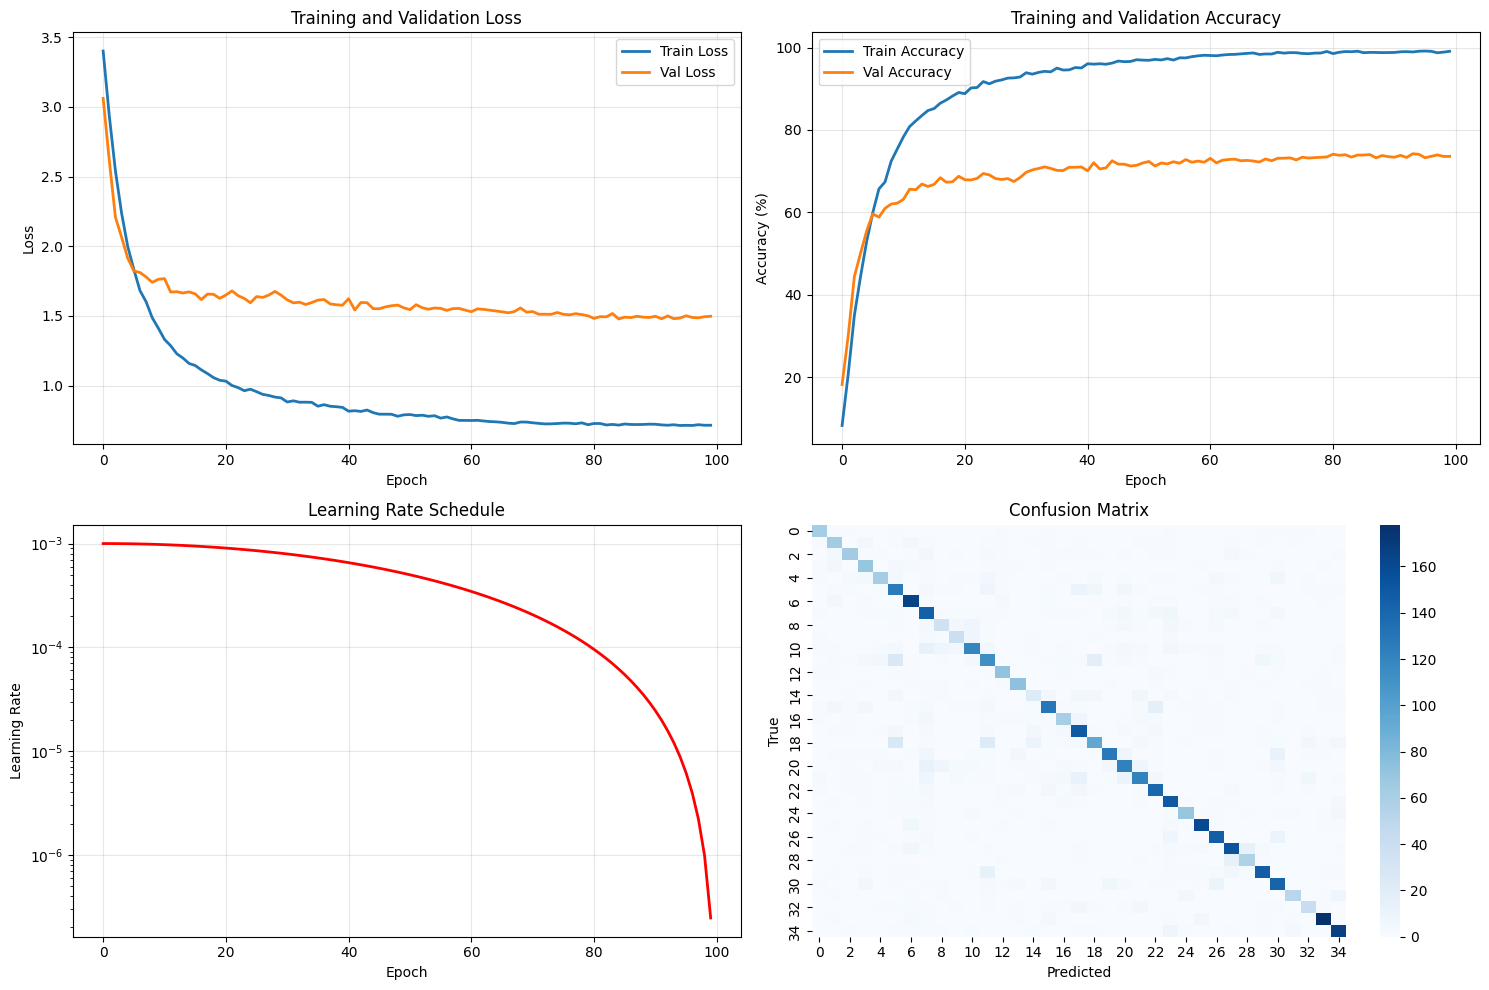

✅ Visualizations created!


In [12]:
print("📊 Creating visualizations...")

# Create plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
ax2.plot(history['val_acc'], label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Learning Rate plot
ax3.plot(history['learning_rates'], color='red', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax4)
ax4.set_title('Confusion Matrix')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('True')

plt.tight_layout()
plt.show()

print("✅ Visualizations created!")

In [13]:
print("💾 Saving models...")

# Save PyTorch model
torch.save(model.state_dict(), 'speech_recognition_model.pth')
print("✅ PyTorch model saved: speech_recognition_model.pth")

# Export to ONNX
try:
    dummy_input = torch.randn(1, 3, config.n_mels, 32).to(device)
    torch.onnx.export(
        model,
        dummy_input,
        'speech_recognition_model.onnx',
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
        opset_version=13
    )
    print("✅ ONNX model exported: speech_recognition_model.onnx")
except Exception as e:
    print(f"❌ ONNX export error: {e}")

# Save class labels
import json
with open('class_labels.json', 'w') as f:
    json.dump(train_dataset.idx_to_label, f)
print("✅ Labels saved: class_labels.json")

print("\n🎯 All models have been saved!")

💾 Saving models...
✅ PyTorch model saved: speech_recognition_model.pth
✅ ONNX model exported: speech_recognition_model.onnx
✅ Labels saved: class_labels.json

🎯 All models have been saved!


In [14]:
def predict_audio(audio_path, model, dataset, device):
    """Predict audio file"""
    try:
        # Load audio
        waveform, sample_rate = torchaudio.load(audio_path)
        
        # Preprocessing
        if sample_rate != config.sample_rate:
            resampler = T.Resample(sample_rate, config.sample_rate)
            waveform = resampler(waveform)
        
        if waveform.shape[1] < config.target_length:
            waveform = F.pad(waveform, (0, config.target_length - waveform.shape[1]))
        else:
            waveform = waveform[:, :config.target_length]
        
        # Create spectrogram
        mel_spec = dataset.transform(waveform)
        mel_spec_db = dataset.to_db(mel_spec)
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        mel_spec_3ch = mel_spec_db.repeat(3, 1, 1)
        
        # Prediction
        model.eval()
        with torch.no_grad():
            mel_spec_3ch = mel_spec_3ch.unsqueeze(0).to(device)
            output = model(mel_spec_3ch)
            probs = F.softmax(output, dim=1)
            prob, predicted = probs.max(1)
        
        predicted_label = dataset.idx_to_label[predicted.item()]
        confidence = prob.item() * 100
        
        print(f"🎤 Prediction: {predicted_label}")
        print(f"📊 Confidence: {confidence:.2f}%")
        
        # Top 3 predictions
        top3_probs, top3_idx = probs.topk(3, dim=1)
        print("\n🏆 Top 3 predictions:")
        for i in range(3):
            label = dataset.idx_to_label[top3_idx[0][i].item()]
            prob = top3_probs[0][i].item() * 100
            print(f"   {i+1}. {label}: {prob:.2f}%")
        
        return predicted_label, confidence
        
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        return None, 0

print("✅ Prediction function created!")
print("\n💡 Usage:")
print("   predicted_label, confidence = predict_audio('audio_file.wav', model, test_dataset, device)")

✅ Prediction function created!

💡 Usage:
   predicted_label, confidence = predict_audio('audio_file.wav', model, test_dataset, device)
